In [1]:
# Notes
# Batch size 32-128
# lr <= 0.0001 for relu
# if we want more data so training > test, can use data augmentation
# experimented with some dropout layers to prevent overfitting, low probability on conv layers, 0.4+ on fc layers
# relu, CrossEntropy and Adam seem to make most sense

In [2]:
import random

import torch, time, gc
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid

plt.rcParams['axes.grid'] = True

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f'Using {torch.cuda.get_device_name(0)}')
SAVE_PATH = "./saves/neural_net.pth"

# Training variables
BATCH_SIZE = 4
EPOCHS = 50
LEARNING_RATE = 0.00001
#learning_rate_testers = [0.1, 0.01, 0.001, 0.00033, 0.0001, 0.00005, 0.000025, 0.00001, 0.0000075, 0.000005, 0.0000033, 0.0000025, 0.000001, 0.0000005]
WEIGHT_DECAY = 0.0005


base_transform = transforms.Compose([
    transforms.Resize((256, 256), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_transform = transforms.Compose([
    base_transform,
    transforms.CenterCrop(256)
])
augment_transform = transforms.Compose([
    train_transform,
    transforms.RandomApply(
        [transforms.RandomApply([transforms.RandomAffine(degrees=359, translate=(0.2, 0.2), shear=(20, 20, 20, 20)),
                                 transforms.RandomHorizontalFlip(1), transforms.RandomVerticalFlip(1)], p=0.7),
         transforms.ColorJitter(brightness=(0.75, 1.25), contrast=(0.75, 1.25), hue=(-0.15, 0.15),
                                saturation=(0.75, 1.25))
         ]
    )
])

val_accuracies, val_losses, train_accuracies, train_losses = [], [], [], []

# Load the train dataset
train_dataset = datasets.Flowers102(root="./data", split="train", transform=train_transform, download=True)
train_miniset = Subset(train_dataset, list(random.randint(0, len(train_dataset)) for i in range(32)))
train_miniset2 = Subset(train_dataset, list(range(320)))
all_train_data = [train_dataset]

# Since augment transform has probability/random changes, we can use it multiple times to generate more training data
for i in range(1):
    all_train_data.append(
        datasets.Flowers102(root="./data", split="train", transform=augment_transform, download=False))
train_dataset_extra = torch.utils.data.ConcatDataset(all_train_data)

train_loader = DataLoader(train_dataset_extra, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Load validation dataset
val_dataset = datasets.Flowers102(root="./data", split="val", transform=base_transform, download=True)
# val_miniset = Subset(val_dataset, random_indexes)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

test_dataset = datasets.Flowers102(root="./data", split="test", transform=base_transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# Define some cnn layers
def ConvLayer(insize: int, outsize: int): # Conv2d layer with ReLU
    return nn.Sequential(nn.Conv2d(insize, outsize, kernel_size=3, padding=1), nn.ReLU())

def ConvUpscale(insize: int, outsize: int, pooled: bool): # Conv2d layer upping feature count with pool
    layer = ConvLayer(insize, outsize)
    if pooled:
        return PooledLayer(outsize, layer)
    return layer

def ConvFlat(size: int, pooled: bool): # Conv2d layer with same feature count, optionally with pool
    layer = ConvLayer(size, size)
    if pooled:
        return PooledLayer(size, layer)
    return layer

def BatchNorm(size: int): # Convenience batch norm
    return nn.BatchNorm2d(size)

def PooledLayer(out_size: int, layer: nn.Module): # Sequentially pool layer passed in, with batch norm
    return nn.Sequential(layer,
                         BatchNorm(out_size),
                         nn.MaxPool2d(2, 2))

class MultiModelCNN(nn.Module):

    def __init__(self, conv_layers_str: [str], final_feature_count: int, final_dim: int):
        super(MultiModelCNN, self).__init__()

        # Conv base
        self.convBase8 = ConvUpscale(3, 8, True)
        self.convBase16 = ConvUpscale(3, 16, True)
        self.convBase32 = ConvUpscale(3, 32, True)
        self.convBase64 = ConvUpscale(3, 64, True)

        # Conv upping feature counts
        # not pooled
        self.conv8_16 = ConvUpscale(8, 16, False)
        self.conv16_32 = ConvUpscale(16, 32, False)
        self.conv32_64 = ConvUpscale(32, 64, False)
        self.conv64_128 = ConvUpscale(64, 128, False)
        self.conv128_256 = ConvUpscale(128, 256, False)
        self.conv256_512 = ConvUpscale(256, 512, False)
        # pooled
        self.conv8_16p = ConvUpscale(8, 16, True)
        self.conv16_32p = ConvUpscale(16 ,32, True)
        self.conv32_64p = ConvUpscale(32, 64, True)
        self.conv64_128p = ConvUpscale(64, 128, True)
        self.conv128_256p = ConvUpscale(128, 256, True)
        self.conv256_512p = ConvUpscale(256, 512, True)

        # Conv keeping feature counts
        # not pooled
        self.conv64 = ConvFlat(64, False)
        self.conv128 = ConvFlat(128, False)
        self.conv256 = ConvFlat(256, False)
        self.conv512 = ConvFlat(512, False)
        # pooled
        self.conv64p = ConvFlat(64, True)
        self.conv128p = ConvFlat(128, True)
        self.conv256p = ConvFlat(256, True)
        self.conv512p = ConvFlat(512, True)

        self.defined_layers = [
            self.convBase8,
            self.convBase16,
            self.convBase32,
            self.convBase64,
            self.conv8_16,
            self.conv16_32,
            self.conv32_64,
            self.conv64_128,
            self.conv128_256,
            self.conv256_512,
            self.conv8_16p,
            self.conv16_32p,
            self.conv32_64p,
            self.conv64_128p,
            self.conv128_256p,
            self.conv256_512p,
            self.conv64,
            self.conv128,
            self.conv256,
            self.conv512,
            self.conv64p,
            self.conv128p,
            self.conv256p,
            self.conv512p,
        ]
        self.defined_layers_str = [
            'convBase8',
            'convBase16',
            'convBase32',
            'convBase64',
            'conv8_16',
            'conv16_32',
            'conv32_64',
            'conv64_128',
            'conv128_256',
            'conv256_512',
            'conv8_16p',
            'conv16_32p',
            'conv32_64p',
            'conv64_128p',
            'conv128_256p',
            'conv256_512p',
            'conv64',
            'conv128',
            'conv256',
            'conv512',
            'conv64p',
            'conv128p',
            'conv256p',
            'conv512p'
        ]

        self.layers = []
        for layer_str in conv_layers_str:
            if layer_str in self.defined_layers_str:
                self.layers.append(self.defined_layers[self.defined_layers_str.index(layer_str)])
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(final_feature_count * final_dim * final_dim, 1024),
            nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(1024, 1024),
                                 nn.ReLU())
        self.fc3 = nn.Linear(1024, 102) # final

    def forward(self, x):
        for layer_i in range(len(self.layers)):
            x = self.layers[layer_i](x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

no_repeat_layers_64 = MultiModelCNN(['convBase8', 'conv8_16p', 'conv16_32p', 'conv32_64p'], 64, 16)
no_repeat_layers_128 = MultiModelCNN(['convBase32', 'conv32_64p', 'conv64_128p'], 128, 32)
no_repeat_layers_256 = MultiModelCNN(['convBase64', 'conv64_128p', 'conv128_256p'], 256, 32)
no_repeat_layers_512 = MultiModelCNN(['convBase64', 'conv64_128p', 'conv128_256p', 'conv256_512p'], 512, 16)

repeat_pool_all_128 = MultiModelCNN(['convBase32', 'conv32_64p', 'conv64p', 'conv64_128p', 'conv128p', 'conv128p'], 128, 4)
repeat_pool_all_256 = MultiModelCNN(['convBase64', 'conv64_128p', 'conv128p', 'conv128_256p', 'conv256p', 'conv256p'], 256, 4)
repeat_pool_all_512 = MultiModelCNN(['convBase64', 'conv64_128p', 'conv128_256p', 'conv256p', 'conv256p', 'conv256_512p', 'conv512p', 'conv512p'],
                                    512, 1)
repeat_pool_all_256_large = MultiModelCNN(['convBase64', 'conv64_128p', 'conv128p', 'conv128_256p', 'conv256p', 'conv256p', 'conv256p'], 256, 2)

repeat_pool_final_128 = MultiModelCNN(['convBase32', 'conv32_64', 'conv64p', 'conv64_128', 'conv128', 'conv128p'], 128, 32)
repeat_pool_final_256 = MultiModelCNN(['convBase64', 'conv64_128', 'conv128p', 'conv128_256', 'conv256', 'conv256p'], 256, 32)
repeat_pool_final_512 = MultiModelCNN(['convBase64', 'conv64_128', 'conv128_256', 'conv256', 'conv256p', 'conv256_512', 'conv512', 'conv512p'],
                                      512, 32)
repeat_pool_final_256_large = MultiModelCNN(['convBase64', 'conv64_128', 'conv128p', 'conv128_256', 'conv256p', 'conv256', 'conv256p'], 256, 16)
# repeat_pool_final_512_large = MultiModelCNN(['convBase64', 'conv64_128', 'conv128p', 'conv128_256', 'conv256', 'conv256p', 'conv256_512', 'conv512', 'conv512p', 'conv512', 'conv512', 'conv512p'], 512, 8)

ALL_NETS = [no_repeat_layers_64,
            repeat_pool_all_256, repeat_pool_all_256_large,
            repeat_pool_final_256]
ALL_NET_LABELS = ['nr64', 'rpa256', 'rpa256L', 'rpf256']
# ['nr512', 'rpa256', 'rpa256L', 'rpf256L']
# ['nr64', 'nr128', 'nr256', 'nr512', 'rpa128', 'rpa256', 'rpa512', 'rpa256L', 'rpf128', 'rpf256', 'rpf256L']

In [3]:
def train_one_epoch(net: nn.Module = None, training_loss: [] = None, training_acc: [] = None, optimizer=None, lr: float = LEARNING_RATE):
    if optimizer is None:
        optimizer = optim.AdamW(net.parameters(), lr=lr)

    net.to(device)
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        labels = torch.eye(102)[labels]  # one hot encode
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)  # train
        labels = torch.argmax(labels, dim=1)  # one hot decode

        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += torch.sum(predicted == labels).sum().item()

    running_loss /= len(train_dataset_extra)
    train_accuracy = 100 * correct / total
    # save data
    training_loss.append(running_loss)
    training_acc.append(train_accuracy)
    print(f'Training Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
    return training_loss, training_acc


In [4]:
def validate_one_epoch(net: nn.Module = None, valid_loss: [] = None, valid_acc: [] = None):
    net.eval()
    with torch.no_grad():
        running_vloss = 0.0
        vcorrect = 0
        vtotal = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            vloss = criterion(outputs, labels)
            running_vloss += vloss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            vtotal += labels.size(0)
            vcorrect += (predicted == labels).sum().item()

        vaccuracy = 100 * vcorrect / vtotal
        running_vloss /= len(val_dataset)

        # save validation data
        valid_loss.append(running_vloss)
        valid_acc.append(vaccuracy)
        print(f'Validation Loss: {running_vloss:.4f}, Accuracy: {vaccuracy:.2f}%')
        return valid_loss, valid_acc

In [5]:
def train_net(net: nn.Module = None, epochs: int = 1, validation_loss=None, validation_accuracy=None,
              training_loss=None, training_accuracy=None, epochs_already_trained: int = 0, lr: float = LEARNING_RATE):
    optimizer = optim.AdamW(net.parameters(), lr=lr)

    if training_accuracy is None:
        training_accuracy = []
    if training_loss is None:
        training_loss = []
    if validation_accuracy is None:
        validation_accuracy = []
    if validation_loss is None:
        validation_loss = []

    epochs += epochs_already_trained
    for epoch in range(epochs_already_trained, epochs):
        print(f'Epoch: [{epoch + 1}/{epochs}]')

        training_loss, training_accuracy = train_one_epoch(net, training_loss=training_loss,
                                                           training_acc=training_accuracy, optimizer=optimizer)
        validation_loss, validation_accuracy = validate_one_epoch(net, valid_loss=validation_loss,
                                                                  valid_acc=validation_accuracy)
        torch.save(net.state_dict(), SAVE_PATH)
        with open("./saves/save_data.txt", "w") as savefile:
            savefile.writelines(str(validation_loss))
            savefile.writelines(str(validation_accuracy))
            savefile.writelines(str(training_loss))
            savefile.writelines(str(training_accuracy))
            savefile.write(str(epoch + 1))
        print("NN saved.")


In [6]:
# def train_net_from_save(epochs: int = 1, save_folder_path: str = "./saves"):
#     print("Resuming training from save.")
#     net = CNN().to(device)
#     net.load_state_dict(torch.load(save_folder_path + "/neural_net.pth"))
#     with open(save_folder_path + "/save_data.txt", "r") as savefile:
#         savelist = savefile.readline().split("]")
#         v_losses, v_accs, t_losses, t_accs = [], [], [], []
#         for vloss in savelist[0][1::].split(","):
#             v_losses.append(float(vloss.strip()))
#         for vacc in savelist[1][1::].split(","):
#             v_accs.append(float(vacc.strip()))
#         for tloss in savelist[2][1::].split(","):
#             t_losses.append(float(tloss.strip()))
#         for tacc in savelist[3][1::].split(","):
#             t_accs.append(float(tacc.strip()))
#         epochs_done = int(savelist[4])
#     print("Net loaded. " + str(epochs_done) + " epochs previously trained.")
#     train_net(net=net, epochs=epochs, validation_loss=v_losses, validation_accuracy=v_accs, training_accuracy=t_accs,
#               training_loss=t_losses, epochs_already_trained=epochs_done)

In [7]:
def test_net(net: nn.Module = None):
    if net is None:
        return
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            # pred_labels = torch.argmax(outputs, axis=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f"Test Accuracy: {(100 * correct / total):.2f}%")

In [9]:
# Clear cuda cache
gc.collect()
torch.cuda.empty_cache()

# Create an instance of the CNN and move it to the device
# cnn = CNN().to(device)
# print(cnn)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()

In [ ]:
print(f"Starting training with lr: {LEARNING_RATE:6f}")
# Start timer
start_time = time.time()

all_t_losses = []
all_t_accs = []
all_v_losses = []
all_v_accs = []

for nn in ALL_NETS:
    print(f'Network {ALL_NETS.index(nn)+1}: {ALL_NET_LABELS[ALL_NETS.index(nn)]}')
    train_net(nn, EPOCHS)
    torch.cuda.empty_cache()
    del nn

    with open("./saves/save_data.txt", "r") as savefile:
        savelist = savefile.readline().split("]")
        t_losses, t_accs, v_losses, v_accs = [], [], [], []
        for vloss in savelist[0][1::].split(","):
            v_losses.append(float(vloss.strip()))
        all_v_losses.append(v_losses)
        for vacc in savelist[1][1::].split(","):
            v_accs.append(float(vacc.strip()))
        # all_v_accs.append(v_accs)
        for tloss in savelist[2][1::].split(","):
            t_losses.append(float(tloss.strip()))
        all_t_losses.append(t_losses)
        for tacc in savelist[3][1::].split(","):
            t_accs.append(float(tacc.strip()))
        all_t_accs.append(t_accs)

# Stop timer
end_time = time.time()
print("Training Complete in: " + time.strftime("%Hh %Mm %Ss", time.gmtime(end_time - start_time)))

Starting training with lr: 0.000010
Network 1: nr64
Epoch: [1/50]
Training Loss: 4.4417, Accuracy: 8.28%
Validation Loss: 4.1075, Accuracy: 10.10%
NN saved.
Epoch: [2/50]
Training Loss: 3.4914, Accuracy: 35.05%
Validation Loss: 3.5356, Accuracy: 19.51%
NN saved.
Epoch: [3/50]
Training Loss: 2.4528, Accuracy: 61.03%
Validation Loss: 3.2101, Accuracy: 24.80%
NN saved.
Epoch: [4/50]
Training Loss: 1.6974, Accuracy: 73.58%
Validation Loss: 3.0552, Accuracy: 26.86%
NN saved.
Epoch: [5/50]
Training Loss: 1.2702, Accuracy: 79.66%
Validation Loss: 2.9838, Accuracy: 27.16%
NN saved.
Epoch: [6/50]
Training Loss: 1.1015, Accuracy: 81.03%
Validation Loss: 2.9865, Accuracy: 26.96%
NN saved.
Epoch: [7/50]
Training Loss: 1.0352, Accuracy: 80.69%
Validation Loss: 2.9509, Accuracy: 28.53%
NN saved.
Epoch: [8/50]
Training Loss: 0.9372, Accuracy: 81.91%
Validation Loss: 2.9353, Accuracy: 29.71%
NN saved.
Epoch: [9/50]
Training Loss: 0.8942, Accuracy: 82.21%
Validation Loss: 3.0637, Accuracy: 24.61%
NN sa

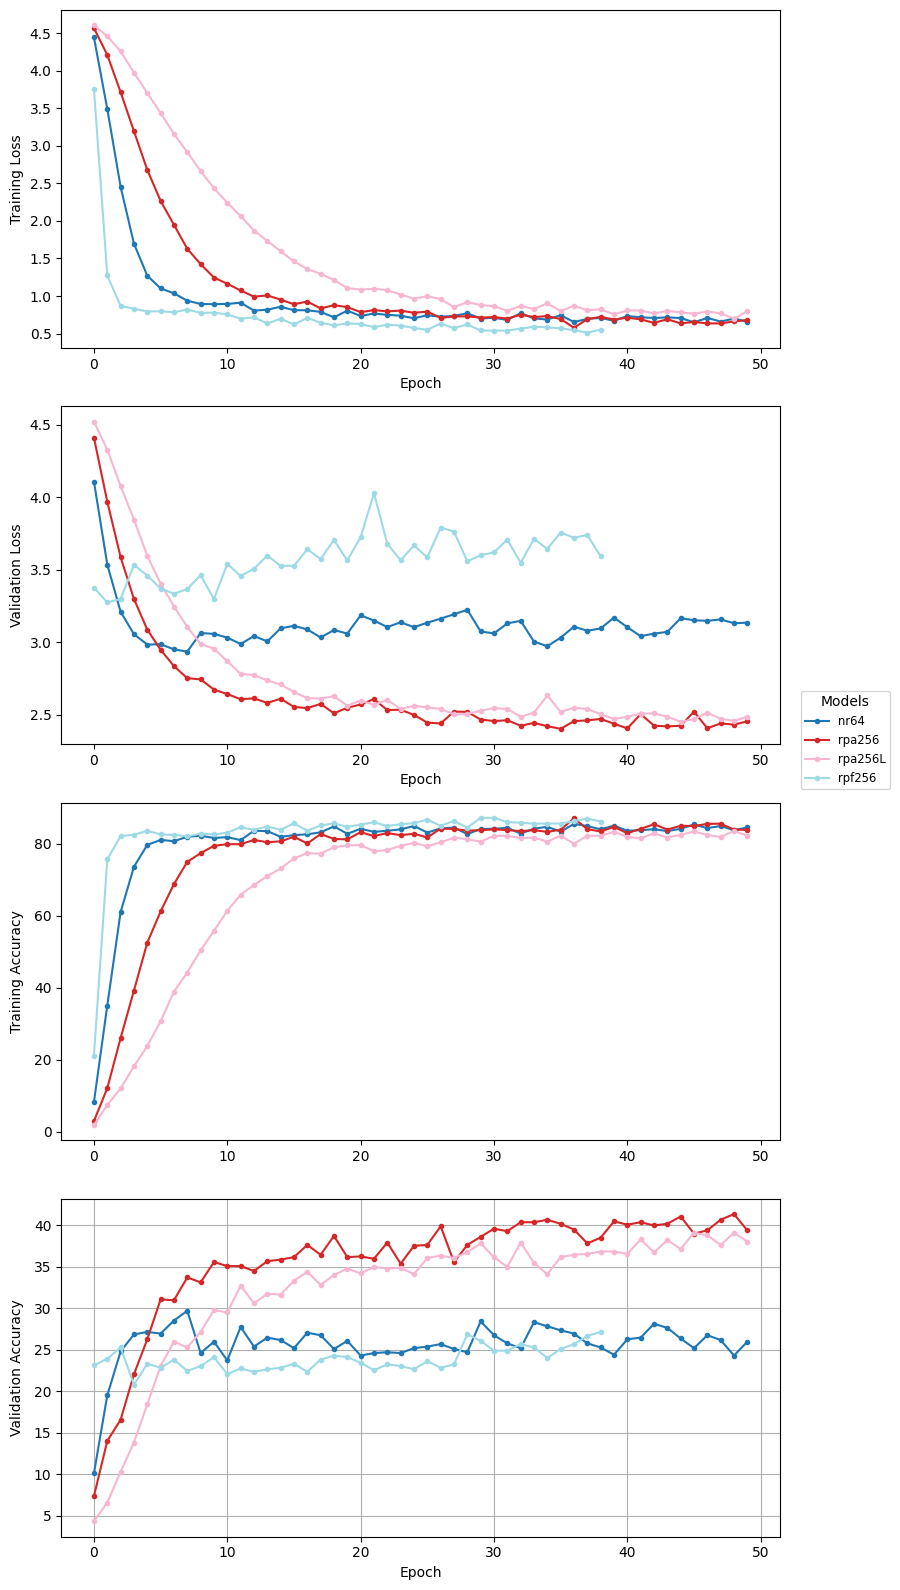

In [7]:
# Plot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid
fig = plt.figure(figsize=(8, 16), tight_layout=True)
gs = grid.GridSpec(nrows=4, ncols=1)
ax_tl = fig.add_subplot(gs[0, 0])
ax_tl.set_xlabel("Epoch")
ax_tl.set_ylabel("Training Loss")
ax_ta = fig.add_subplot(gs[2, 0])
ax_tl.set_xlabel("Epoch")
ax_ta.set_ylabel("Training Accuracy")
ax_vl = fig.add_subplot(gs[1, 0])
ax_vl.set_xlabel("Epoch")
ax_vl.set_ylabel("Validation Loss")
ax_va = fig.add_subplot(gs[3, 0])
ax_va.set_xlabel("Epoch")
ax_va.set_ylabel("Validation Accuracy")

n_plots = round(len(all_t_losses))
colours = iter(plt.cm.tab20(np.linspace(0, 1, len(all_t_losses))))


for lr_i in range(n_plots):
  t_losses = all_t_losses[lr_i]
  t_accs = all_t_accs[lr_i]
  v_losses = all_v_losses[lr_i]
  v_accs = all_v_accs[lr_i]
  c = next(colours)
  ax_tl.plot(t_losses, c=c, marker=".")
  ax_ta.plot(t_accs, c=c, marker=".")
  ax_vl.plot(v_losses, c=c, marker=".")
  ax_va.plot(v_accs, c=c, marker=".")

fig.legend(title="Models", labels=ALL_NET_LABELS, fontsize="small", loc=3, bbox_to_anchor=(1, 0.5))
fig.align_labels()
plt.grid()
plt.savefig("./models_grouped.png")
plt.show()

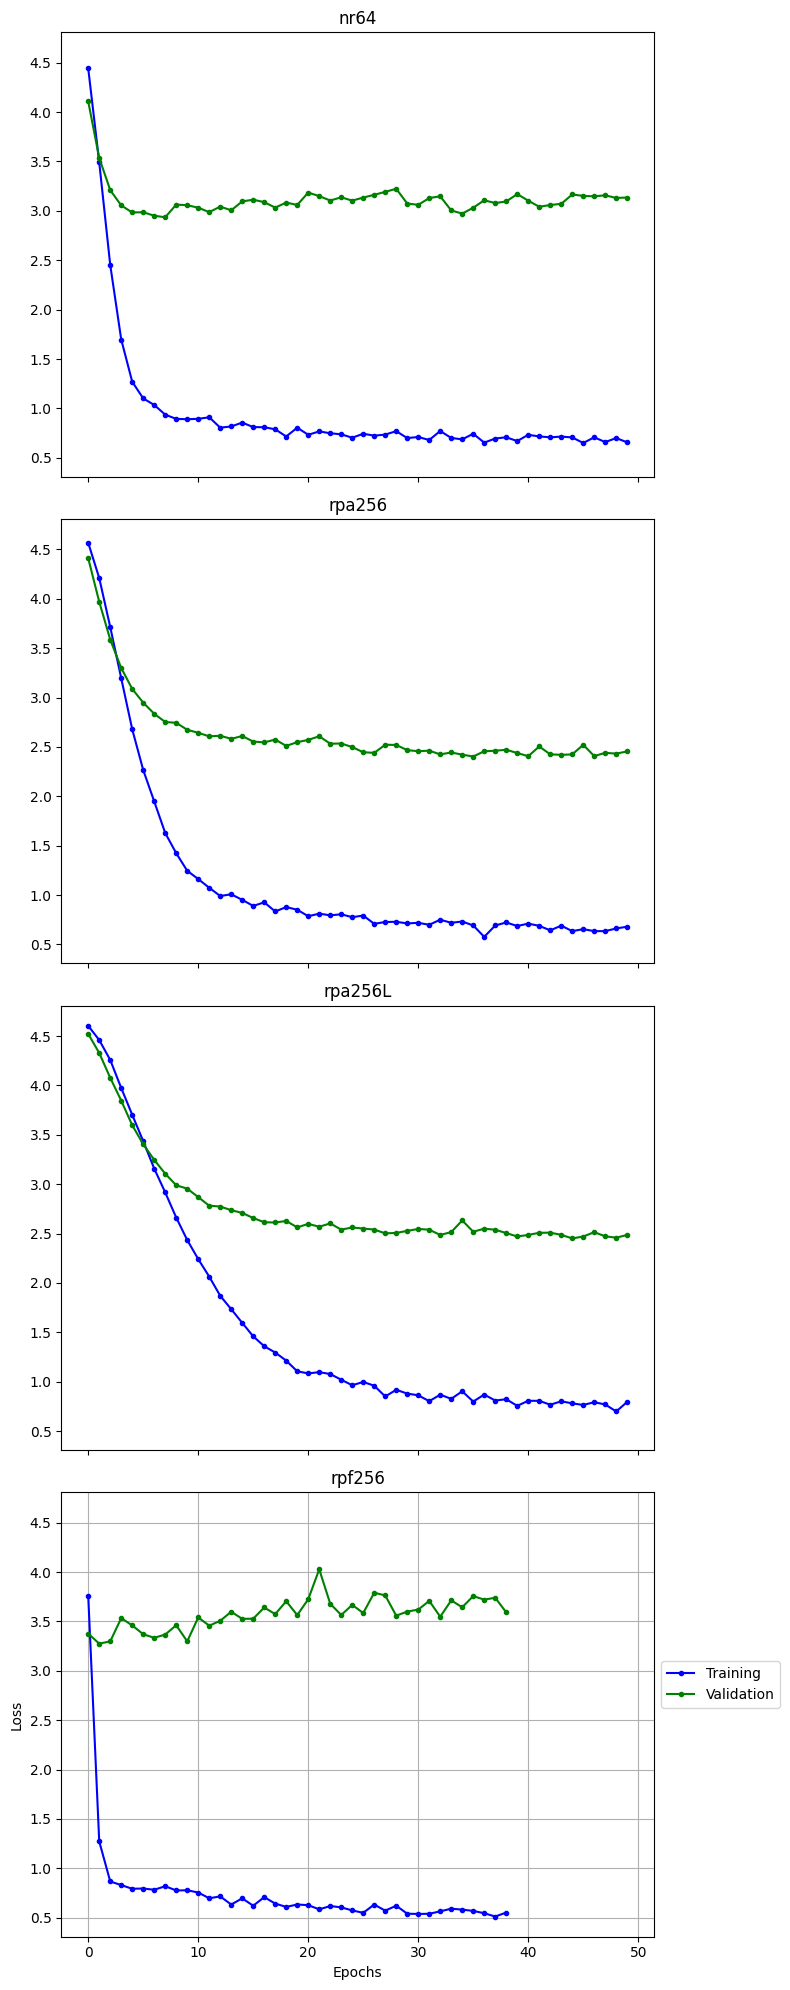

In [9]:
fig, ax = plt.subplots(n_plots, figsize=(8, 20), tight_layout=True, sharex=True, sharey=True)
for plot in range(n_plots):
  t_loss = all_t_losses[plot]
  v_loss = all_v_losses[plot]
  ax[plot].plot(t_loss, 'b', marker=".")
  ax[plot].plot(v_loss, 'g', marker=".")
  ax[plot].title.set_text(ALL_NET_LABELS[plot])

plt.legend(labels=["Training", "Validation"], loc=3, bbox_to_anchor=(1, 0.5))
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.grid()
plt.savefig("./models_separate.png")
plt.show()